<h4>Load libraries</h4>

In [1]:
import os
import numpy as np
import pandas as pd
import pymongo
import statistics
import matplotlib.pyplot as plt
from matplotlib import cm

<h4>Load environment variables</h4>

In [2]:
%load_ext dotenv
%dotenv

In [3]:
mongo_username = os.environ.get("MONGO_USERNAME")
mongo_password = os.environ.get("MONGO_PASSWORD")

<h4>Connect to database</h4>

In [4]:
mongo_client = pymongo.MongoClient(
    "mongodb://" + str(mongo_username) + ":" + str(mongo_password) + "@localhost:27017")
mongo_db = mongo_client["trading"]

<h4>Load data from database</h4>

In [5]:
#load data from the 1st iteration
data = mongo_db["cross_ma_opt"].find()
timeseries_df = pd.DataFrame(list(data))
#load data from the 2nd iteration
data_2 = mongo_db["cross_ma_opt_2"].find()
timeseries_2_df = pd.DataFrame(list(data_2))

<h4>Load OHLCV from database</h4>

In [6]:
ohlcv_db = mongo_db['binance']['BTC/USDT']['1m']["ohlcv"].find()
ohlcv_df = pd.DataFrame(list(ohlcv_db))
ts = ohlcv_df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].to_numpy()
ts_full = ts[ts[:, 0].argsort()]
close_np = ts_full[[i for i in range(288000, ts_full.shape[0], 1440)],4]

<h4>Rate of change calculation with step 30 (days in month)</h4>

In [7]:
step = 30 #average days in month

def rate_of_change(x):
    """
    Per month Rate of change calculation
    """
    return [(x[i] - x[i-step]) / x[i-step] for i in range(step, len(x), step)]
    
timeseries_df['change'] = timeseries_df['result'].apply(lambda x: rate_of_change(x))
timeseries_2_df['change'] = timeseries_2_df['result'].apply(lambda x: rate_of_change(x))

<h4>Statistics calculations</h4>

In [8]:
def calc_statistic(in_data):
    in_data['min'] = in_data['change'].apply(lambda x: min(x))
    in_data['max'] = in_data['change'].apply(lambda x: max(x))
    in_data['average'] = in_data['change'].apply(lambda x: statistics.mean(x))
    in_data['std'] = in_data['change'].apply(lambda x: statistics.stdev(x))
    in_data['total'] = in_data['result'].apply(lambda x: (x[-1] - x[0]) / x[0])
    return in_data
timeseries_df = calc_statistic(timeseries_df)
timeseries_2_df = calc_statistic(timeseries_2_df)

<h4>Select interesting ranges</h4>

In [9]:
timeseries_interest_df = timeseries_df[(timeseries_df['window_1'] < 40000) & (timeseries_df['window_2'] > 50000) & (timeseries_df['window_2'] < 150000)]
timeseries_2_interest_df = timeseries_2_df[(timeseries_2_df['window_1'] < 1000) & (timeseries_2_df['window_2'] > 1000)]

<h4>ROI</h4>

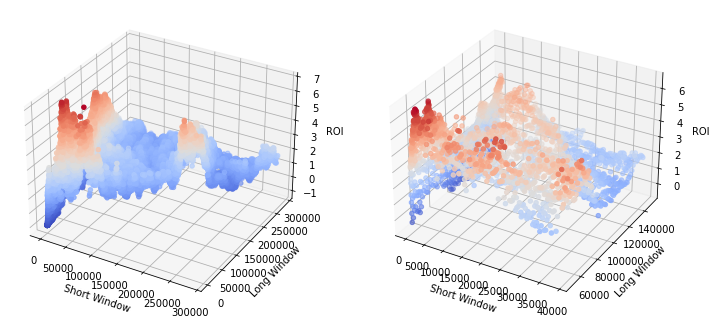

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,12),subplot_kw=dict(projection='3d'))
ax[0].scatter(
    timeseries_df['window_1'],
    timeseries_df['window_2'],
    timeseries_df['total'],
    c=timeseries_df['total'],
    cmap=cm.coolwarm)
ax[1].scatter(
    timeseries_interest_df['window_1'],
    timeseries_interest_df['window_2'],
    timeseries_interest_df['total'],
    c=timeseries_interest_df['total'],
    cmap=cm.coolwarm)
for i in range(2):
    ax[i].set_xlabel("Short Window")
    ax[i].set_ylabel("Long Window")
    ax[i].set_zlabel("ROI")
plt.show()

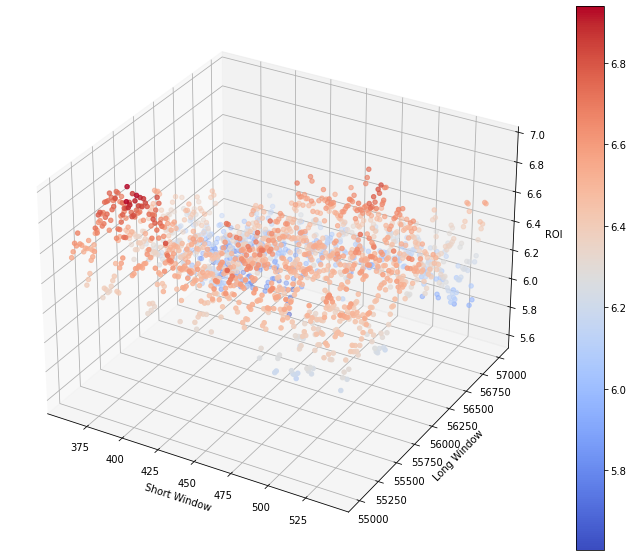

In [11]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scatter_plot = ax.scatter(
    timeseries_2_interest_df['window_1'],
    timeseries_2_interest_df['window_2'],
    timeseries_2_interest_df['total'],
    c=timeseries_2_interest_df['total'],
    cmap=cm.coolwarm)
plt.colorbar(scatter_plot)
ax.set_xlabel("Short Window")
ax.set_ylabel("Long Window")
ax.set_zlabel("ROI")
plt.show()

<h4>Average monthly rate of change</h4>

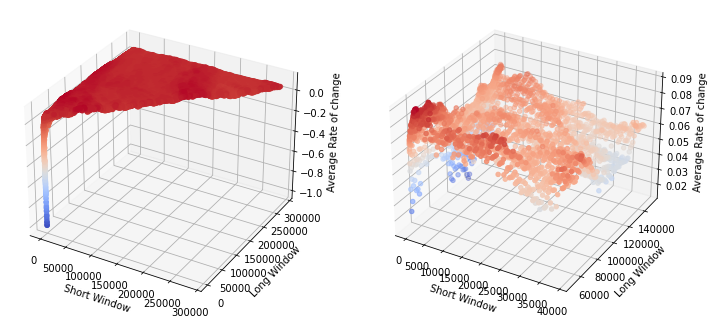

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,6),subplot_kw=dict(projection='3d'))
ax[0].scatter(
    timeseries_df['window_1'],
    timeseries_df['window_2'],
    timeseries_df['average'],
    c=timeseries_df['average'],
    cmap=cm.coolwarm)
ax[1].scatter(
    timeseries_interest_df['window_1'],
    timeseries_interest_df['window_2'],
    timeseries_interest_df['average'],
    c=timeseries_interest_df['average'],
    cmap=cm.coolwarm)
for i in range(2):
    ax[i].set_xlabel("Short Window")
    ax[i].set_ylabel("Long Window")
    ax[i].set_zlabel("Average Rate of change")
plt.show()

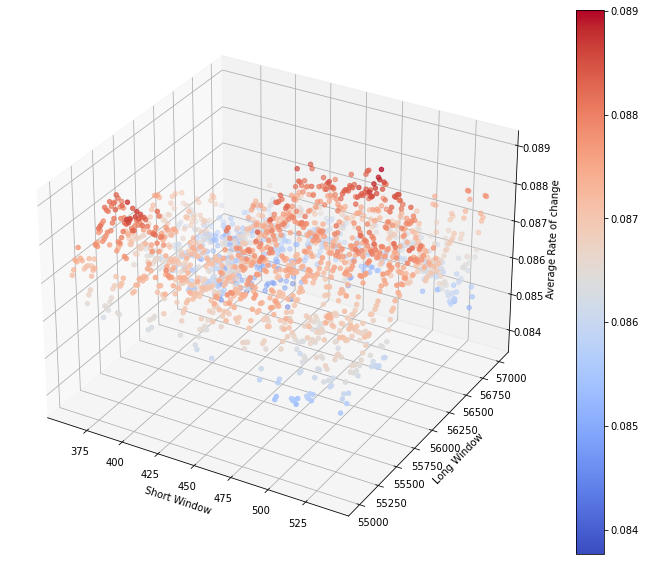

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scatter_plot = ax.scatter(
    timeseries_2_interest_df['window_1'],
    timeseries_2_interest_df['window_2'],
    timeseries_2_interest_df['average'],
    c=timeseries_2_interest_df['average'],
    cmap=cm.coolwarm)
ax.set_xlabel("Short Window")
ax.set_ylabel("Long Window")
ax.set_zlabel("Average Rate of change")
plt.colorbar(scatter_plot)
plt.show()

<h4>Minimum monthly rate of change</h4>

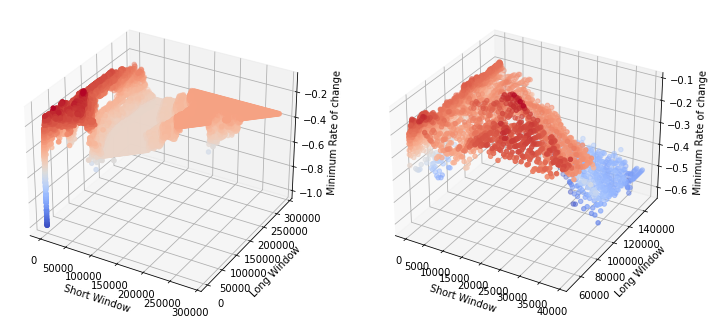

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,12),subplot_kw=dict(projection='3d'))
ax[0].scatter(
    timeseries_df['window_1'],
    timeseries_df['window_2'],
    timeseries_df['min'],
    c=timeseries_df['min'],
    cmap=cm.coolwarm)
ax[1].scatter(
    timeseries_interest_df['window_1'],
    timeseries_interest_df['window_2'],
    timeseries_interest_df['min'],
    c=timeseries_interest_df['min'],
    cmap=cm.coolwarm)
for i in range(2):
    ax[i].set_xlabel("Short Window")
    ax[i].set_ylabel("Long Window")
    ax[i].set_zlabel("Minimum Rate of change")
plt.show()

<h4>Maximum monthly rate of change</h4>

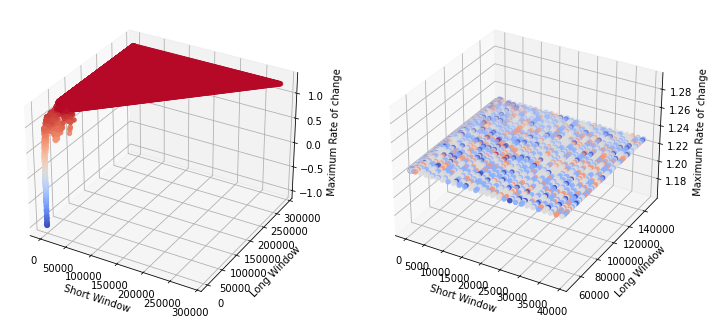

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,12),subplot_kw=dict(projection='3d'))
ax[0].scatter(
    timeseries_df['window_1'],
    timeseries_df['window_2'],
    timeseries_df['max'],
    c=timeseries_df['max'],
    cmap=cm.coolwarm)
ax[1].scatter(
    timeseries_interest_df['window_1'],
    timeseries_interest_df['window_2'],
    timeseries_interest_df['max'],
    c=timeseries_interest_df['max'],
    cmap=cm.coolwarm)
for i in range(2):
    ax[i].set_xlabel("Short Window")
    ax[i].set_ylabel("Long Window")
    ax[i].set_zlabel("Maximum Rate of change")
plt.show()

<h4>Standart deviation of monthly rate of change</h4>

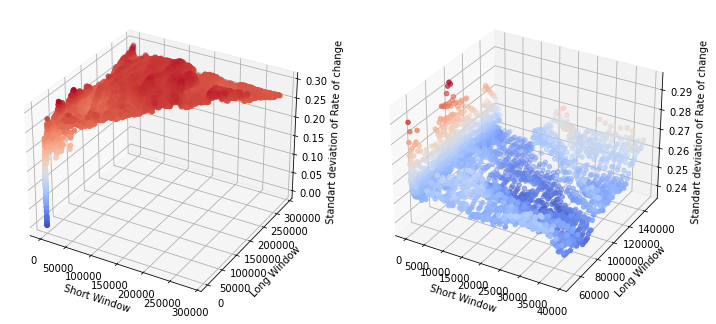

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,12),subplot_kw=dict(projection='3d'))
ax[0].scatter(
    timeseries_df['window_1'],
    timeseries_df['window_2'],
    timeseries_df['std'],
    c=timeseries_df['std'],
    cmap=cm.coolwarm)
ax[1].scatter(
    timeseries_interest_df['window_1'],
    timeseries_interest_df['window_2'],
    timeseries_interest_df['std'],
    c=timeseries_interest_df['std'],
    cmap=cm.coolwarm)
for i in range(2):
    ax[i].set_xlabel("Short Window")
    ax[i].set_ylabel("Long Window")
    ax[i].set_zlabel("Standart deviation of Rate of change")
plt.show()

In [17]:
max_total_id = timeseries_interest_df['total'].idxmax()
timeseries_df.iloc[max_total_id]

_id                                  6241d3b4a0c5427bc848a18b
window_1                                                420.0
window_2                                              56160.0
result      [10575.0, 10613.31, 10577.44272, 10577.44272, ...
change      [-0.04597878690905766, -0.07834025591876397, 0...
min                                                 -0.190788
max                                                  1.227664
average                                              0.087362
std                                                  0.250529
total                                                6.462785
Name: 3459, dtype: object

In [18]:
max_min_roc_id = timeseries_interest_df['min'].idxmax()
timeseries_df.iloc[max_min_roc_id]

_id                                  6241d3b4a0c5427bc848af64
window_1                                              18720.0
window_2                                              93600.0
result      [10575.0, 10613.31, 10583.25, 10120.0, 9713.24...
change      [-0.11343885554363123, -0.07474790615855482, 0...
min                                                 -0.113439
max                                                  1.227664
average                                              0.068825
std                                                  0.240825
total                                                3.919735
Name: 7004, dtype: object

In [19]:
max_max_roc_id = timeseries_interest_df['max'].idxmax()
timeseries_df.iloc[max_max_roc_id]

_id                                  6241d3b4a0c5427bc848aafb
window_1                                              10080.0
window_2                                             105120.0
result      [10575.0, 10613.31, 10583.25, 10120.0, 9713.24...
change      [-0.08406563462462743, -0.006325606583765888, ...
min                                                 -0.262114
max                                                  1.227664
average                                              0.067851
std                                                  0.248105
total                                                3.474786
Name: 5875, dtype: object

In [20]:
max_average_roc_id = timeseries_interest_df['average'].idxmax()
timeseries_df.iloc[max_average_roc_id]

_id                                  6241d3b4a0c5427bc848a257
window_1                                                480.0
window_2                                              56160.0
result      [10575.0, 10613.31, 10634.049280000001, 10634....
change      [-0.051978419463809995, -0.08215097996215855, ...
min                                                 -0.198902
max                                                  1.227664
average                                               0.08745
std                                                  0.250496
total                                                6.462395
Name: 3663, dtype: object

In [21]:
max_average_roc_id_2 = timeseries_2_interest_df['average'].idxmax()
timeseries_2_df.iloc[max_average_roc_id_2]

_id                                  624475e9aba612c6aee3ac14
window_1                                                497.0
window_2                                              56393.0
result      [10575.0, 10613.31, 10685.106960000001, 10685....
change      [-0.04397978045522277, -0.08528197532101515, 0...
min                                                 -0.194438
max                                                  1.227664
average                                              0.089007
std                                                  0.249958
total                                                6.809447
Name: 1516, dtype: object

In [22]:
max_total_id_2 = timeseries_2_interest_df['total'].idxmax()
timeseries_2_df.iloc[max_total_id_2]

_id                                  624475e9aba612c6aee3a799
window_1                                                391.0
window_2                                              55141.0
result      [10575.0, 10570.017600000001, 10570.0176000000...
change      [-0.05034396587038236, -0.08901521528496213, 0...
min                                                 -0.187583
max                                                  1.227664
average                                              0.088652
std                                                   0.24979
total                                                6.938986
Name: 369, dtype: object

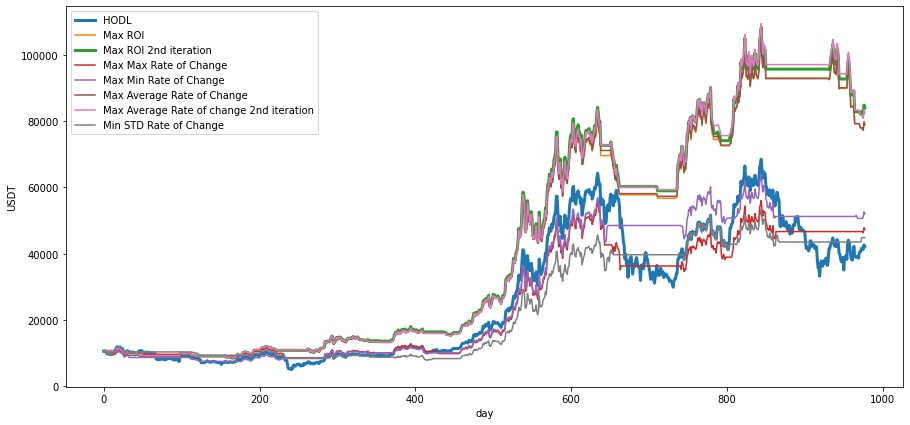

In [23]:
timeseries_len = len(timeseries_df['result'].iat[0])
x_vals = np.arange(0, timeseries_len, 1) 
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(
    x_vals,
    close_np,
    label="HODL",
    linewidth=3)
ax.plot(
    x_vals,
    timeseries_df['result'].iat[max_total_id],
    label="Max ROI")
ax.plot(
    x_vals,
    timeseries_2_df['result'].iat[max_total_id_2],
    label="Max ROI 2nd iteration",
    linewidth=3)
ax.plot(
    x_vals,
    timeseries_df['result'].iat[max_max_roc_id],
    label="Max Max Rate of Change")
ax.plot(
    x_vals,
    timeseries_df['result'].iat[max_min_roc_id],
    label="Max Min Rate of Change")
ax.plot(
    x_vals,
    timeseries_df['result'].iat[max_average_roc_id],
    label="Max Average Rate of Change")
ax.plot(
    x_vals,
    timeseries_2_df['result'].iat[max_average_roc_id_2],
    label="Max Average Rate of change 2nd iteration")
ax.plot(
    x_vals,
    timeseries_df['result'].iat[timeseries_interest_df['std'].idxmin()],
    label="Min STD Rate of Change")
ax.legend()

ax.set_xlabel("day")
ax.set_ylabel("USDT")

plt.show()